In [112]:
import os
from shutil import copy

#import tensorflow as tf
#import tensorflow.keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Input, BatchNormalization, ReLU
from keras.regularizers import l1
from keras.optimizers import RMSprop, Adagrad, Adam, SGD
from keras.applications import VGG16
from keras.applications.mobilenetv2 import MobileNetV2
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix

import PIL.Image

from pprint import pprint

# Getting Started

In [2]:
def applyBoundingBox(image, boundingbox):
    x = int(float(boundingbox[0]))
    y = int(float(boundingbox[1]))
    width = int(float(boundingbox[2]))
    height = int(float(boundingbox[3]))
    #print([x, y, width, height])
        
    imagecropped = image[y:y+height,x:x+width]
    
#     print("len(image): ", len(image))
#     print("len(image)[0]: ", len(image[0]))
#     print("len(image)[0][0]: ", len(image[0][0]))
    
#     print("len(imagecropped): ", len(imagecropped))
#     print("len(imagecropped)[0]: ", len(imagecropped[0]))
#     print("len(imagecropped)[0][0]: ", len(imagecropped[0][0]))
    return imagecropped

In [3]:
def copyImage(src, label, tr_te, dst="", image=None):
    
        cat = os.path.join(tr_te, label)
        new_dst = os.path.join(dst,cat)
        
        #print(src)
        #print(cat)
        #print(new_dst)
        
        # check if directory exists
        if os.path.isdir(new_dst):
            pass
        else:        
            # make diretory
            os.mkdir(new_dst)

        #print(new_dst)
        if image is not None:
            file = src.split("/")[-1]
            new_dst = os.path.join(new_dst,file)
            result = PIL.Image.fromarray(image)
            result.save(new_dst)
        else:
            copy(src, new_dst)

In [4]:
#generateData("./CUB_200_2011/CUB_200_2011/CUB_200_2011/train.txt", "./Outex_TC_00030.tar/Outex-TC-00030/images/", "C:/Users/Sophie/Documents/GitHub/CSI5139/csi5139_a2/Outex-TC-00030/test/")

drt = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/"
drt_images = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/images"
dst = "./CUB_200_2011_generator/"
dst_bb = "./CUB_200_2011_generator_boundingbox/"

# images.txt
with open(os.path.join(drt, "images.txt"), "r", encoding='utf-8') as f:
    images_txt = f.read().splitlines()

# train_test_split.txt
with open(os.path.join(drt, "train_test_split.txt"), "r", encoding='utf-8') as f:
    tr_te_txt = f.read().splitlines()

# image_class_labels.txt
with open(os.path.join(drt, "image_class_labels.txt"), "r", encoding='utf-8') as f:
    class_labels_txt = f.read().splitlines()

# bounding_boxes.txt
with open(os.path.join(drt, "bounding_boxes.txt"), "r", encoding='utf-8') as f:
    bounding_boxes_txt = f.read().splitlines()

print(images_txt[:2])
print(tr_te_txt[:2])
print(class_labels_txt[:2])
print(bounding_boxes_txt[:2])
print("# images_txt: ", len(images_txt))
print("# tr_te_txt: ", len(tr_te_txt))
print("# class_labels_txt: ", len(class_labels_txt))
print("# bounding_boxes_txt: ", len(bounding_boxes_txt))

#birdspecies_subset = {"cardinal": 17, "american_goldﬁnch": 47, "evening_grosbeak": 55, "song_sparrow": 129, "tree_sparrow": 130, "house_sparrow": 118, "fox_sparrow":120, "canada_warbler":162, "myrtle warbler": 171, "house_wren": 196 , "red-winged_blackbird": 10, "boat_tailed_grackle":49}
birdspecies_subset = {"17": "cardinal", "47": "american_goldﬁnch", "55": "evening_grosbeak", "129": "song_sparrow", "130": "tree_sparrow", "118": "house_sparrow", "120": "fox_sparrow", "162": "canada_warbler", "171": "myrtle warbler", "196": "house_wren", "10": "red-winged_blackbird", "49": "boat_tailed_grackle"}
label_subset = set(birdspecies_subset.keys())
print("label_subset: ", label_subset)

boundingbox = True
bb_input_train = []
bb_input_test = []
for i, label in enumerate(class_labels_txt):
    label = label.split(' ')[-1]
    if label in label_subset:
        file = images_txt[i].split(' ')[-1]
        tr_te = tr_te_txt[i].split(' ')[-1]
        b_b = bounding_boxes_txt[i].split(' ')[1:]
        
        if tr_te == "1":
            tr_te = "train"
            bb_input_train.append(b_b)
        elif tr_te == "0":
            tr_te = "test"
            bb_input_test.append(b_b)
        else:
            break
        
#         print(file)
#         src = os.path.join(drt_images, file)
        
#         if boundingbox:
#             image = PIL.Image.open(src)
#             image = np.array(image)
#             image = applyBoundingBox(image, b_b)
#             copyImage(file, label, tr_te, dst_bb, image)
#         else:
#             src = os.path.join(drt_images, file)
#             copyImage(src, label, tr_te, dst) 

bb_input_train = np.array(bb_input_train)
bb_input_test = np.array(bb_input_test)

['1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg']
['1 0', '2 1']
['1 1', '2 1']
['1 60.0 27.0 325.0 304.0', '2 139.0 30.0 153.0 264.0']
# images_txt:  11788
# tr_te_txt:  11788
# class_labels_txt:  11788
# bounding_boxes_txt:  11788
label_subset:  {'55', '171', '10', '17', '49', '118', '120', '47', '196', '129', '162', '130'}


In [5]:
# drt = "./CUB_200_2011/CUB_200_2011/CUB_200_2011/"
# bb_input = []
# # bounding_boxes.txt
# with open(os.path.join(drt, "bounding_boxes.txt"), "r", encoding='utf-8') as f:
#     bounding_boxes_txt = f.read().splitlines()
    
# print("# bounding_boxes_txt: ", len(bounding_boxes_txt))

# for i, label in enumerate(bounding_boxes_txt):
#     bb = bounding_boxes_txt[i].split(' ')[1:]
#     bb_input.append(bb)
    
print("# bb_input_train: ", len(bb_input_train))
print(bb_input_train[:2])

print("# bb_input_test: ", len(bb_input_test))
print(bb_input_test[:2])

# bb_input_train:  359
[['187.0' '129.0' '131.0' '226.0']
 ['130.0' '124.0' '351.0' '205.0']]
# bb_input_test:  357
[['110.0' '144.0' '171.0' '156.0']
 ['218.0' '39.0' '205.0' '360.0']]


In [6]:
datagen = ImageDataGenerator(rescale=.1/255)

train_batchsize = 32 # 160 images per 68 classes
test_batchsize = 32 # 20 images per 68 classes

train_generator = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/train/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=train_batchsize,
    class_mode="categorical"
)

test_generator = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/test/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=test_batchsize,
    class_mode="categorical"
)

print("Train generator length: ", len(train_generator))
print("Test generator length: ", len(test_generator))
print("Target size: ", train_generator.target_size)

Found 359 images belonging to 12 classes.
Found 357 images belonging to 12 classes.
Train generator length:  12
Test generator length:  12
Target size:  (96, 96)


In [76]:
datagen = ImageDataGenerator(rescale=.1/255)

train_batchsize = 359 # 160 images per 68 classes
test_batchsize = 357 # 20 images per 68 classes

train_generator_temp = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/train/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=train_batchsize,
    class_mode="categorical",
    shuffle=False
)

test_generator_temp = datagen.flow_from_directory(
    directory=r"./CUB_200_2011_generator/test/",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=test_batchsize,
    class_mode="categorical",
    shuffle=False
)

print("Train generator length: ", len(train_generator_temp))
print("Test generator length: ", len(test_generator_temp))
print("Target size: ", train_generator_temp.target_size)

Found 359 images belonging to 12 classes.
Found 357 images belonging to 12 classes.
Train generator length:  1
Test generator length:  1
Target size:  (96, 96)


In [77]:
Xtrain, ytrain = train_generator_temp.next()
Xtest, ytest = test_generator_temp.next()
print("Xtrain: ", Xtrain.shape)
print("ytrain: ", ytrain.shape)
print("Xtest: ", Xtest.shape)
print("ytest: ", ytest.shape)

#print(X[100])
print(ytrain)

print("Generator indices: ", test_generator_temp.class_indices)
print("Generator filenames:", test_generator_temp.filenames[:10])

Xtrain:  (359, 96, 96, 3)
ytrain:  (359, 12)
Xtest:  (357, 96, 96, 3)
ytest:  (357, 12)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Generator indices:  {'10': 0, '118': 1, '120': 2, '129': 3, '130': 4, '162': 5, '17': 6, '171': 7, '196': 8, '47': 9, '49': 10, '55': 11}
Generator filenames: ['10\\Red_Winged_Blackbird_0006_6005.jpg', '10\\Red_Winged_Blackbird_0007_3706.jpg', '10\\Red_Winged_Blackbird_0009_5841.jpg', '10\\Red_Winged_Blackbird_0010_6386.jpg', '10\\Red_Winged_Blackbird_0011_5845.jpg', '10\\Red_Winged_Blackbird_0013_5762.jpg', '10\\Red_Winged_Blackbird_0017_4116.jpg', '10\\Red_Winged_Blackbird_0022_4483.jpg', '10\\Red_Winged_Blackbird_0024_4180.jpg', '10\\Red_Winged_Blackbird_0027_4123.jpg']


# Model

# Regularization

Evaluate model for classiﬁcation with three diﬀerent regularizations: dropout, batch normalization and l1-regularization.

#### Dropout

In [159]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[8].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()
mv2_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_28[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [160]:
for layer in mv2_transfer.layers:
    print(layer, layer.trainable)
    
mv2_transfer.summary()

hist_mv2_dropout = mv2_transfer.fit(Xtrain, ytrain, 
        batch_size=32,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x0000023CB3AE1908> False
<keras.layers.convolutional.Conv2D object at 0x0000023CA2434208> True
<keras.layers.normalization.BatchNormalization object at 0x0000023CB3AE1DD8> True
<keras.layers.advanced_activations.ReLU object at 0x0000023CB3AE1B70> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000023CB3A759E8> True
<keras.layers.normalization.BatchNormalization object at 0x0000023CB3A95E48> True
<keras.layers.advanced_activations.ReLU object at 0x0000023CB3A8BF98> True
<keras.layers.convolutional.Conv2D object at 0x0000023CA2CF49E8> True
<keras.layers.normalization.BatchNormalization object at 0x0000023CA2D352B0> True
<keras.layers.advanced_activations.ReLU object at 0x0000023CC716DE80> True
<keras.layers.core.Flatten object at 0x0000023CB3AE18D0> True
<keras.layers.core.Dense object at 0x0000023CC7107CC0> True
<keras.layers.core.Dropout object at 0x0000023CC70E5080> True
<keras.layers.core.Dense object at 0x0000023CC70E5EB8

#### Batch Normalization

In [165]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[8].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()
mv2_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_31[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [166]:
for layer in mv2_transfer.layers:
    print(layer, layer.trainable)
    
mv2_transfer.summary()

hist_mv2_batchnorm = mv2_transfer.fit(Xtrain, ytrain, 
        batch_size=16,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x0000023C4C7B8518> False
<keras.layers.convolutional.Conv2D object at 0x0000023C4C7B8208> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C4C7C42E8> True
<keras.layers.advanced_activations.ReLU object at 0x0000023C4C7C4C50> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000023C4C7C4AC8> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C4C7C47F0> True
<keras.layers.advanced_activations.ReLU object at 0x0000023C4C7F8E10> True
<keras.layers.convolutional.Conv2D object at 0x0000023C4C821EB8> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C4C867588> True
<keras.layers.advanced_activations.ReLU object at 0x0000023C4C928BE0> True
<keras.layers.core.Flatten object at 0x0000023C4C7B84E0> True
<keras.layers.core.Dense object at 0x0000023C15E28208> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C73B27780> True
<keras.layers.core.Dense object a

#### L1 Regularization

In [163]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[8].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu', activity_regularizer=l1(0.1))(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()
mv2_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_30[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [164]:
for layer in mv2_transfer.layers:
    print(layer, layer.trainable)
    
mv2_transfer.summary()

hist_mv2_l1reg = mv2_transfer.fit(Xtrain, ytrain, 
        batch_size=32,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x0000023CA1C90FD0> False
<keras.layers.convolutional.Conv2D object at 0x0000023CA1C90F28> True
<keras.layers.normalization.BatchNormalization object at 0x0000023CA1C90518> True
<keras.layers.advanced_activations.ReLU object at 0x0000023CA1C90F60> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000023CA1CF97F0> True
<keras.layers.normalization.BatchNormalization object at 0x0000023CA1C88128> True
<keras.layers.advanced_activations.ReLU object at 0x0000023CA1C6AC88> True
<keras.layers.convolutional.Conv2D object at 0x0000023CA1C3B390> True
<keras.layers.normalization.BatchNormalization object at 0x0000023CA1C0ADA0> True
<keras.layers.advanced_activations.ReLU object at 0x0000023C8F0E8320> True
<keras.layers.core.Flatten object at 0x0000023CA1C90358> True
<keras.layers.core.Dense object at 0x0000023C4C535240> True
<keras.layers.core.Dense object at 0x0000023C4C5350B8> True
_______________________________________________________

#### Compare models

In [168]:
def plotAccuracy(data, ylabel, title=None):
    for reg in data:
        test_acc = reg[0]
        labl = reg[1]
        iterations = list(range(len(test_acc)))
        plt.plot(iterations, test_acc, label=labl)      

    plt.xlabel("Number of Iterations")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"
    if title:
        plt.title(title)

    plt.show()

In [ ]:
# compare accuracy
data = [[hist_mv2_dropout.history['acc'], "train"], [hist_mv2_dropout.history['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "Dropout")

data = [[hist_mv2_batchnorm.history['acc'], "train"], [hist_mv2_batchnorm.history['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "Batch Normalization")

data = [[hist_mv2_l1reg.history['acc'], "train"], [hist_mv2_l1reg.history['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "L1-regularization")

data = [[hist_mv2_batchnorm.history['loss'], "train"], [hist_mv2_batchnorm.history['val_loss'], "test"]]
plotAccuracy(data, "Loss", "Batch Normalization")

Batch normalization gives the best train and test accuracy, followed by dropout and l1-regularization. In addition, batch normalization decreases in test loss and test accuracy (in small decrements), so with continued number of interations, the test accuracy should improve further. In contrast, dropout and batchnorm give more of a constant test loss an accuracy.

# Optimizer

Pick model using batch normalization (best performing model from above) and evaluate three diﬀerent optimizers: SGD, Adam, RMSprop.

#### SGD

SGD optimizer is already evaluated above with batch normalization.

In [182]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[8].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
sgd = SGD()
mv2_transfer.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_37[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [183]:
for layer in mv2_transfer.layers:
    print(layer, layer.trainable)
    
mv2_transfer.summary()

hist_mv2_batchnorm_sgd = mv2_transfer.fit(Xtrain, ytrain, 
        batch_size=32,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x0000023C370E4470> False
<keras.layers.convolutional.Conv2D object at 0x0000023CF8E36D30> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C370E4080> True
<keras.layers.advanced_activations.ReLU object at 0x0000023C370E4240> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000023C370E47F0> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C370E4828> True
<keras.layers.advanced_activations.ReLU object at 0x0000023C370B39E8> True
<keras.layers.convolutional.Conv2D object at 0x0000023C37087780> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C3704C9E8> True
<keras.layers.advanced_activations.ReLU object at 0x0000023CB44787B8> True
<keras.layers.core.Flatten object at 0x0000023C370E45F8> True
<keras.layers.core.Dense object at 0x0000023D5EDACF60> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D5E962B38> True
<keras.layers.core.Dense object a

#### Adam

In [175]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[8].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
adam = Adam()
mv2_transfer.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_33[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [176]:
for layer in mv2_transfer.layers:
    print(layer, layer.trainable)
    
mv2_transfer.summary()

hist_mv2_batchnorm_adam = mv2_transfer.fit(Xtrain, ytrain, 
        batch_size=16,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x0000023D0C8F1CF8> False
<keras.layers.convolutional.Conv2D object at 0x0000023D0C8F1DA0> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D0C8F1F60> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D0C8F1D30> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000023D0C8ED080> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D0C8ED518> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D0C938F60> True
<keras.layers.convolutional.Conv2D object at 0x0000023D01A76A58> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D01AE88D0> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D225482E8> True
<keras.layers.core.Flatten object at 0x0000023D0C8F1C88> True
<keras.layers.core.Dense object at 0x0000023D23B37CF8> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D23B376A0> True
<keras.layers.core.Dense object a

#### RMSprop

In [179]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[8].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(12, activation='softmax')(x)

# Transfer models
mv2_transfer = Model(inputs=mobilenetv2_model.input, outputs=x)

# SGD optimizer
rmsprop = RMSprop(lr=0.0001)
mv2_transfer.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_35[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [180]:
for layer in mv2_transfer.layers:
    print(layer, layer.trainable)
    
mv2_transfer.summary()

hist_mv2_batchnorm_rmsprop = mv2_transfer.fit(Xtrain, ytrain, 
        batch_size=16,
        epochs=epochs,
        validation_data=(Xtest, ytest),
        verbose=1,
        shuffle=True)

score = mv2_transfer.evaluate(Xtrain, ytrain)
print(score)

score = mv2_transfer.evaluate(Xtest, ytest)
print(score)

<keras.engine.input_layer.InputLayer object at 0x0000023D2370E588> False
<keras.layers.convolutional.Conv2D object at 0x0000023D2370E1D0> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D2370E0F0> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D2370E160> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000023D23703198> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D2370E080> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D236E3278> True
<keras.layers.convolutional.Conv2D object at 0x0000023D236BC550> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D2367DDD8> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D0D5F4CF8> True
<keras.layers.core.Flatten object at 0x0000023D2370E630> True
<keras.layers.core.Dense object at 0x0000023D0D5F4828> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D0D5D7C88> True
<keras.layers.core.Dense object a

#### Compare models

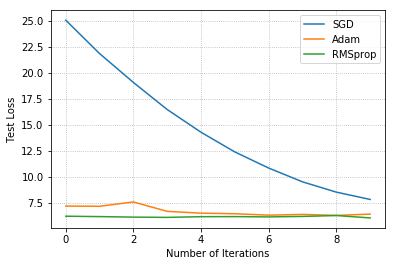

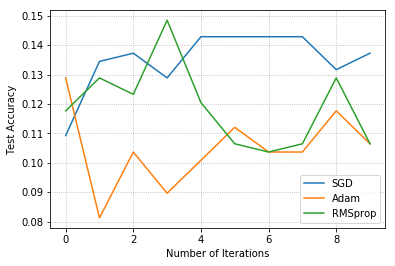

In [75]:
# compare accuracy
data = [[hist_mv2_batchnorm.history['acc'], "train"], [hist_mv2_batchnorm.history['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "SGD")

data = [[hist_mv2_batchnorm_adam.history['acc'], "train"], [hist_mv2_batchnorm_adam.history['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "Adam")

data = [[hist_mv2_batchnorm_rmsprop.history['acc'], "train"], [hist_mv2_batchnorm_rmsprop.history['val_acc'], "test"]]
plotAccuracy(data, "Accuracy", "RMSprop")

# data = [[hist_mv2_batchnorm.history['loss'], "train"], [hist_mv2_batchnorm.history['val_loss'], "test"]]
# plotAccuracy(data, "Loss", "Batch Normalization")

Comparing the performance, SGD is faster, since it takes about 5-6s/step, whereas Adam and RMSprop take 8-9s/step. On the other hand RMSprop reaches training accuracy the fastests, followed closely by Adam, whereas SGD take longer. Therefore with an optimizer such as RMSprop, although it takes 8-9s/step, we can stop training much more quickly since it reaches almost perfect training accuracy within a couple epochs. In contrast, SGD reaches training accuracy more incrementally, and takes 10 epoches without reaching perfect training accuracy. However this may be why it is better able to react and increasing test accuracy more incrementally as well.

# Multi-task Learning

In [188]:
mobilenetv2_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(96, 96, 3))
mobilenetv2_model.summary()

epochs = 10

# last layers output
x = mobilenetv2_model.layers[8].output
# Flatten as before
x = ReLU()(x)
x = Flatten()(x)

# Classifier task
classifier = Dense(256, activation='relu', name='clf_1')(x)
classifier = BatchNormalization(name='clf_bn')(classifier)
classifier = Dense(12, activation='softmax', name='clf_2')(classifier)

# Regression task
regression_task = Dense(256, activation='relu', name='rt_1')(x)
regression_task = BatchNormalization(name='rt_bn')(regression_task)
regression_task = Dense(4, name='rt_2')(regression_task)

# Transfer models
mv2_multitask_transfer = Model(inputs=mobilenetv2_model.input, outputs=[classifier, regression_task])

sgd = SGD(lr=0.0008)
mv2_multitask_transfer.compile(optimizer=sgd, loss=['categorical_crossentropy', 'mse'], metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_40[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [189]:
for layer in mv2_multitask_transfer.layers:
    print(layer, layer.trainable)
    
mv2_multitask_transfer.summary()

hist_mv2_multitask = mv2_multitask_transfer.fit(
        X, [y, bb_input_train],
        batch_size=32,
        epochs=epochs,
        validation_data=(X, [y, bb_input_train]),
        verbose=1)

<keras.engine.input_layer.InputLayer object at 0x0000023C1267FD30> False
<keras.layers.convolutional.Conv2D object at 0x0000023C1267FE10> True
<keras.layers.normalization.BatchNormalization object at 0x0000023C1267FF60> True
<keras.layers.advanced_activations.ReLU object at 0x0000023C1267FEB8> True
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000023D820DB0B8> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D820DB550> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D820A4F28> True
<keras.layers.convolutional.Conv2D object at 0x0000023D7750FEB8> True
<keras.layers.normalization.BatchNormalization object at 0x0000023D775937F0> True
<keras.layers.advanced_activations.ReLU object at 0x0000023D9C3DD2B0> True
<keras.layers.core.Flatten object at 0x0000023C1267FCF8> True
<keras.layers.core.Dense object at 0x0000023D9DA052E8> True
<keras.layers.core.Dense object at 0x0000023D9DA1FC88> True
<keras.layers.normalization.BatchNormalization object a

Epoch 10/10
359/359 [==============================] - 35s 98ms/step - loss: 434.4723 - dense_122_loss: 0.2614 - regression_task2_loss: 434.2109 - dense_122_acc: 0.9944 - regression_task2_acc: 0.8802 - val_loss: 1615.5069 - val_dense_122_loss: 0.2648 - val_regression_task2_loss: 1615.2421 - val_dense_122_acc: 0.9916 - val_regression_task2_acc: 0.8942


# Additional Annotations